## PROJETO 2 - MEGADADOS
### Integrantes: Pedro Vero Fontes e Lucas Leal Vale
### Pesquisa: Ford x Honda

Neste projeto iremos análisar a dinâmica da aparição das palavras Ford e Honda em um snapshot da web-brasil.

Para isso utilizaremos a tecnologia spark para realização dos cálculos em cluster na AWS, por questões praticas o projeto fora pré-desenvolvido e testado no jupyter notebook em escala reduzida.

In [1]:
import pyspark
import math
import csv

In [2]:
# Criando o contexto Spark

sc = pyspark.SparkContext(appName = 'hey mundo')

In [3]:
sc

<SparkContext master=local[*] appName=hey mundo>

Nesta etapa é feita a leitura dos arquivos de dados disponíveis. Na célula abaixo está exemplificado a leitura local e em comentário o path que fora utilizado no spark da AWS.

In [4]:
rdd = sc.sequenceFile('part-00000')
#rdd = sc.sequenceFile('s3://megadados-alunos/web-brasil')

In [5]:
result = rdd.take(10)

### Tratando dados
As funções abaixo são responsáveis por tratar as páginas de acordo com as palavras que queremos analisar.

A conta palavras é a mais simples de todas, ela é responsável por contar quantas vezes todas as palavras aparecem numa página. 

In [6]:
def conta_palavras(item):
    url, conteudo = item
    palavras = conteudo.strip().split()
    return [(palavra.lower(),1) for palavra in palavras if palavra.isalpha()] 

A conta_docs_ford_honda faz a mesma coisa que a função conta_palavras, mas somente se as palavras Ford **e** Honda estiverem na página

In [7]:
def conta_docs_ford_honda(item):
    url, conteudo = item
    palavras = conteudo.strip().split()
    if 'ford' in palavras and 'honda' in palavras:
        return [(palavra.lower(),1) for palavra in (palavras) if palavra.isalpha()]
    else:
        return []

A conta_docs_ford faz a mesma coisa que a função conta_palavras, mas somente se a palavra Ford estiver na página

In [8]:
def conta_docs_ford(item):
    url, conteudo = item
    palavras = conteudo.strip().split()
    if 'ford' in palavras and 'honda' not in palavras:
        return [(palavra.lower(),1) for palavra in (palavras) if palavra.isalpha()]
    else:
        return []

A conta_docs_honda faz a mesma coisa que a função conta_palavras, mas somente se a palavra Honda estiver na página

In [9]:
def conta_docs_honda(item):
    url, conteudo = item
    palavras = conteudo.strip().split()
    if 'honda' in palavras and 'ford' not in palavras:
        return [(palavra.lower(),1) for palavra in (palavras) if palavra.isalpha()]
    else:
        return []

A função junta_contagens é responsável por somar a aparição repetida de palavras por função

In [10]:
def junta_contagens(nova_contagem, contagem_atual):
    return (nova_contagem + contagem_atual)

Nas quatro seguintes células, estamos utilizando as funções anteriores no snapshot disponível e salvando as listas retornadas em váriaveis para análises futuras.

In [11]:
rdd_doc_freq_ford_honda = rdd.flatMap(conta_docs_ford_honda).reduceByKey(junta_contagens)

In [12]:
rdd_doc_freq_ford = rdd.flatMap(conta_docs_ford).reduceByKey(junta_contagens)

In [13]:
rdd_doc_freq_honda = rdd.flatMap(conta_docs_honda).reduceByKey(junta_contagens)

In [14]:
rdd_palavra_freq = rdd.flatMap(conta_palavras).reduceByKey(junta_contagens)

Nas quatro células abaixo é possivel se ter uma pré-visualização das palavras que mais apareceram em cada um dos recortes.

In [15]:
rdd_palavra_freq.take(10)

[('login', 11306),
 ('senha', 8876),
 ('no', 208400),
 ('esqueci', 1585),
 ('musicatração', 4),
 ('nostracastlecastle', 4),
 ('musiccaytronicscbscd', 4),
 ('recordschina', 4),
 ('starcmc', 4),
 ('musicdccdead', 4)]

In [16]:
rdd_doc_freq_ford_honda.take(10)

[('últimas', 16),
 ('das', 20),
 ('todas', 21),
 ('verificação', 1),
 ('possível', 3),
 ('no', 77),
 ('agosto', 17),
 ('março', 15),
 ('foi', 13),
 ('apontada', 1)]

In [17]:
rdd_doc_freq_ford.take(10)

[('carpoint', 36),
 ('perfil', 12),
 ('nissan', 20),
 ('fernando', 13),
 ('julho', 86),
 ('mário', 6),
 ('agosto', 43),
 ('tem', 38),
 ('modelos', 6),
 ('no', 101)]

In [18]:
rdd_doc_freq_honda.take(10)

[('automóvel', 14),
 ('veicular', 9),
 ('no', 515),
 ('garantir', 6),
 ('saída', 5),
 ('peças', 35),
 ('diminuir', 1),
 ('precisa', 15),
 ('todas', 26),
 ('foi', 115)]

In [19]:
rdd.count()

36133

In [20]:
rdd_palavra_freq.count()

419299

In [21]:
rdd_doc_freq_ford_honda.count()

4208

In [22]:
rdd_doc_freq_ford.count()

3123

In [23]:
rdd_doc_freq_honda.count()

6710

Abaixo fizemos um recorte das dez palavras mais frequentes que apareceram em cada um dos recortes anteriores.

no recorte pelas palavras Ford e Honda:

In [24]:
result_ford_honda = rdd_doc_freq_ford_honda.collect()
sorted(result_ford_honda, key=lambda x : -x[1])[:10]

[('gasolina', 1834),
 ('serie', 1744),
 ('mecanico', 1491),
 ('automatico', 1092),
 ('de', 1040),
 ('trator', 786),
 ('pa', 651),
 ('e', 557),
 ('carregadeira', 456),
 ('turbo', 451)]

no recorte pela palavra Ford:

In [25]:
result_ford = rdd_doc_freq_ford.collect()
sorted(result_ford, key=lambda x : -x[1])[:10]

[('de', 780),
 ('do', 296),
 ('o', 281),
 ('e', 254),
 ('caminhão', 234),
 ('a', 220),
 ('cavalo', 184),
 ('mecânico', 179),
 ('que', 165),
 ('respostas', 139)]

no recorte pela palavra Honda:

In [26]:
result_honda = rdd_doc_freq_honda.collect()
sorted(result_honda, key=lambda x : -x[1])[:10]

[('de', 3223),
 ('a', 1716),
 ('o', 1676),
 ('e', 1295),
 ('que', 1228),
 ('em', 931),
 ('do', 849),
 ('um', 738),
 ('é', 713),
 ('da', 682)]

In [27]:
N = rdd.count()

Na célula abaixo, estamos filtrando as palavras que aparecem muitas vezes e que terão pouco peso para as análises posteriores. Exemplos dessas palavras são: "a", "o', "e", "de".

In [28]:
DOC_COUNT_MIN = 5
DOC_COUNT_MAX = 0.7*N
def filtra_doc_freq(item):
    contagem = item[1]
    return (contagem < DOC_COUNT_MAX) & (contagem >= DOC_COUNT_MIN)

rdd_palavra_freq_filter_filtrado = rdd_palavra_freq.filter(filtra_doc_freq)
# rdd_doc_freq_filter_filtrado = rdd_doc_freq.filter(filtra_doc_freq)

In [29]:
rdd_doc_freq_filter_filtrado_ford_honda = rdd_doc_freq_ford_honda.filter(filtra_doc_freq)

In [30]:
rdd_doc_freq_filter_filtrado_ford = rdd_doc_freq_ford.filter(filtra_doc_freq)

In [31]:
rdd_doc_freq_filter_filtrado_honda = rdd_doc_freq_honda.filter(filtra_doc_freq)

Os resultados desse filtro foram:

In [32]:
rdd_doc_freq_filter_filtrado_ford_honda.take(10)

[('últimas', 16),
 ('das', 20),
 ('todas', 21),
 ('no', 77),
 ('agosto', 17),
 ('março', 15),
 ('foi', 13),
 ('outros', 6),
 ('nissan', 61),
 ('elétrica', 5)]

In [33]:
rdd_doc_freq_filter_filtrado_ford.take(10)

[('carpoint', 36),
 ('perfil', 12),
 ('nissan', 20),
 ('fernando', 13),
 ('julho', 86),
 ('mário', 6),
 ('agosto', 43),
 ('tem', 38),
 ('modelos', 6),
 ('no', 101)]

In [34]:
rdd_doc_freq_filter_filtrado_honda.take(10)

[('automóvel', 14),
 ('veicular', 9),
 ('no', 515),
 ('garantir', 6),
 ('saída', 5),
 ('peças', 35),
 ('precisa', 15),
 ('todas', 26),
 ('foi', 115),
 ('boa', 62)]

In [35]:
rdd_doc_freq_ford_honda.count()

4208

In [36]:
rdd_doc_freq_ford.count()

3123

In [37]:
rdd_doc_freq_honda.count()

6710

A função abaixo cálcula o inverse document frequency - idf, de cada palavra que aparecer na lista passada a ela. Este é responsável por dar pesos a cada palavra, de maneira prática, palavras com idf muito alto são palavras que aparecem pouco com provaveis erros de gráfia ou códigos numéricos.

In [38]:
def computa_idf(item):
    palavra,contagem = item
    idf = math.log10(N/contagem)
    return (palavra,idf)

Calculando o idf do recorte mais completo:

In [39]:
rdd_idf = rdd_palavra_freq_filter_filtrado.map(computa_idf)

Abaixo, a função que normaliza a frequencia de aparição de cada palavra passada a ela.

In [40]:
def freq_normalized(item):
    palavra,contagem = item
    freq = math.log10(1 + contagem)
    return(palavra,freq)
    

Rodando a função de normalização para cada recorte

In [41]:
rdd_freq = rdd_palavra_freq_filter_filtrado.map(freq_normalized)

In [42]:
rdd_freq_ford_honda = rdd_doc_freq_filter_filtrado_ford_honda.map(freq_normalized)

In [43]:
rdd_freq_ford = rdd_doc_freq_filter_filtrado_ford.map(freq_normalized)

In [44]:
rdd_freq_honda = rdd_doc_freq_filter_filtrado_honda.map(freq_normalized)

Nas células abaixo estão exemplos das palavras que apareceram com maior frequência em cada uma das listas.

No recorte total:

In [45]:
sorted(rdd_freq.collect(), key= lambda x: x[1])[-15:]

[('conosco', 4.334353208383518),
 ('seus', 4.3355180758942335),
 ('online', 4.337858429041094),
 ('blog', 4.339013945111108),
 ('setembro', 4.339888497223747),
 ('universidade', 4.340404451432455),
 ('direitos', 4.3460007009567505),
 ('minha', 4.346802686265524),
 ('for', 4.358639051893465),
 ('plástica', 4.3656751404559175),
 ('lojas', 4.372654294203733),
 ('nova', 4.387959019712346),
 ('serviço', 4.389786062316935),
 ('quem', 4.393645386605536),
 ('anos', 4.3958329201019835)]

No recorte de ford e honda:

In [46]:
sorted(rdd_freq_ford_honda.collect(), key= lambda x: x[1])[-15:]

[('a', 2.432969290874406),
 ('escavadeira', 2.437750562820388),
 ('flex', 2.499687082618404),
 ('alcool', 2.534026106056135),
 ('diesel', 2.53655844257153),
 ('turbo', 2.655138434811382),
 ('carregadeira', 2.6599162000698504),
 ('e', 2.7466341989375787),
 ('pa', 2.81424759573192),
 ('trator', 2.8959747323590648),
 ('de', 3.017450729510536),
 ('automatico', 3.038620161949703),
 ('mecanico', 3.17376882313665),
 ('serie', 3.241795431295199),
 ('gasolina', 3.263636068588108)]

No recorte Ford:

In [47]:
sorted(rdd_freq_ford.collect(), key= lambda x: x[1])[-15:]

[('mais', 2.0681858617461617),
 ('janeiro', 2.0791812460476247),
 ('com', 2.089905111439398),
 ('é', 2.113943352306837),
 ('respostas', 2.146128035678238),
 ('responder', 2.146128035678238),
 ('que', 2.220108088040055),
 ('mecânico', 2.255272505103306),
 ('cavalo', 2.2671717284030137),
 ('a', 2.3443922736851106),
 ('caminhão', 2.3710678622717363),
 ('e', 2.406540180433955),
 ('o', 2.450249108319361),
 ('do', 2.4727564493172123),
 ('de', 2.8926510338773004)]

No recorte Honda:

In [48]:
sorted(rdd_freq_honda.collect(), key= lambda x: x[1])[-15:]

[('se', 2.677606952720493),
 ('no', 2.7126497016272113),
 ('não', 2.798650645445269),
 ('para', 2.8048206787211623),
 ('com', 2.82865989653532),
 ('da', 2.8344207036815323),
 ('é', 2.8536982117761744),
 ('um', 2.8686444383948255),
 ('do', 2.929418925714293),
 ('em', 2.9694159123539814),
 ('que', 3.089551882886454),
 ('e', 3.1126050015345745),
 ('o', 3.2245330626060857),
 ('a', 3.2347702951609163),
 ('de', 3.508395033133053)]

O recorte Honda aparentemente não teve um filtro bem sucedido enquanto o mesmo filtro para o recorte Ford e Ford&Honda funcionou sem problemas. Contudo isso apenas no local.

## Relevância
Agora indo para o próximo passo devemos cruzar os valores de idf de cada palavra com a sua frequência de aparição em cada recorte. Para obtermos assim a relevância de cada item.

No dataset total:

In [49]:
controle = rdd_freq \
    .join(rdd_idf)\
    .map(lambda x: (x[0],x[1][0]*x[1][1]))\
    .takeOrdered(100,key = lambda x: -x[1])

No dataset Ford&Honda:

In [50]:
relevancia_ford_honda = rdd_freq_ford_honda\
    .join(rdd_idf)\
    .map(lambda x: (x[0],x[1][0]*x[1][1]))\
    .takeOrdered(100,key = lambda x: -x[1])

No dataset Ford:

In [51]:
relevancia_ford = rdd_freq_ford\
    .join(rdd_idf)\
    .map(lambda x: (x[0],x[1][0]*x[1][1]))\
    .takeOrdered(100,key = lambda x: -x[1])

No dataset Honda:

In [52]:
relevancia_honda = rdd_freq_honda\
    .join(rdd_idf)\
    .map(lambda x: (x[0],x[1][0]*x[1][1]))\
    .takeOrdered(100,key = lambda x: -x[1])

Como toda analise anterior fora feita no cluster seria necessario exportar os resultados para um csv para podermos retornar ao jupyter notebook e analisá-los.
Com isso em mente, salvamos cada um dos datasets anteriores em um arquivo .csv.

In [53]:
with open('projetoLocal.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerows(controle)

In [54]:
with open('ford_hondaLocal.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerows(relevancia_ford_honda)

In [55]:
with open('fordLOcal.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerows(relevancia_ford)

In [56]:
with open('hondaLocal.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerows(relevancia_honda)

In [57]:
with open('hondaLocal.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerows(relevancia_honda)

## Resultados
Tudo que fora feito acima em jupyter notebook rodou no spark e os dataset resultados foram salvos e serão lidos nas próximas células para sua respectiva análise.

In [58]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

Lendo os Datasets Resultantes:

In [59]:
df_ford_honda = pd.read_csv("ford_honda.csv", index_col=0)
df_ford = pd.read_csv("ford.csv", index_col=0)
df_honda = pd.read_csv("honda.csv", index_col=0)


In [60]:
df_ford_honda.head()

,relevancia
palavra,
cdinturbo,14.284196
kranekan,14.284196
motonivieladora,14.284187
tiptron,14.282978
macanico,14.281128


Para visualização dos resultados fora surgerido um Grafico WordCloud, e encontramos na internet o seguinte forma de gerá-los:

### Ford

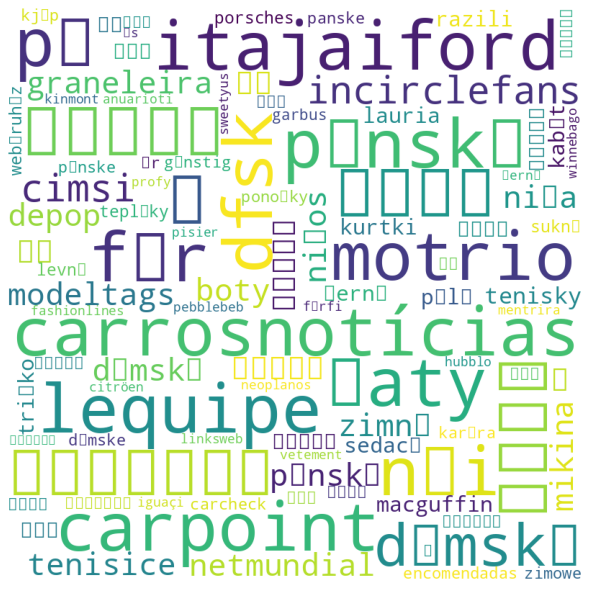

In [61]:
"""
Codigo retirado em:
https://www.geeksforgeeks.org/generating-word-cloud-python/, 
acesso 3/12/2020 
"""
df = pd.read_csv(r"ford.csv", encoding ="utf_8") 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.palavra: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                 stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Quando analisamos os dados do web-brasil para ford, fora retornado muitos dados em japones e arabe o que comprometeu um pouco essa análise. Mas palavras como carros, noticias, carpoint, citroen e porshes indicam que a pesquisa de fato era sobre uma montadora de carros e que seu filtro funcionou.

### Honda

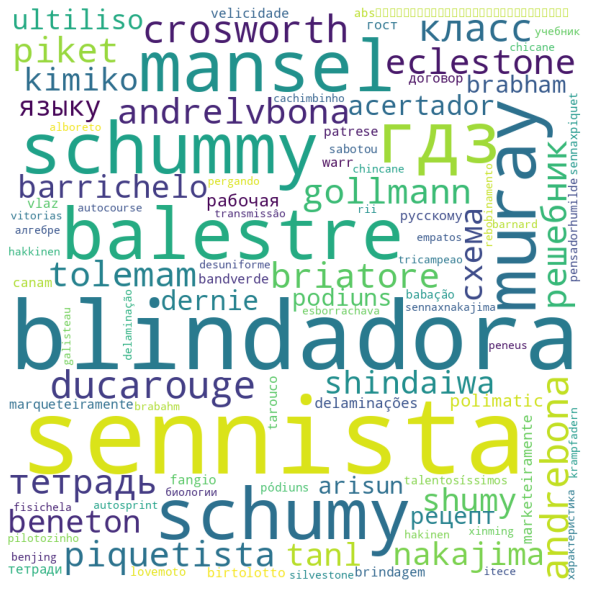

In [62]:
"""
Codigo retirado em:
https://www.geeksforgeeks.org/generating-word-cloud-python/, 
acesso 3/12/2020 
"""
df = pd.read_csv(r"honda.csv", encoding ="UTF-8") 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.palavra: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                 stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Os resultados para o dataset Honda também vieram com muitas coisas em línguas estrangeiras. Dessa vez apareceu um pouco de Russo, mas o interessante deste plot é ter aparecisdo uma nova classe de palavras como piquetista e sennista o que indicam fans de formula um comentando sobre seus gostos e preferencias, alem dessas palavras apareceram piket e barrichelo que são outros corredores.  
Também, provavelmente por causa dessas paginas serem relacionadas à fans é que aparecem algumas palavras depreciativas como pilotozinho, sabotou e babação.
Outra palavra muito presente entre o dataset Honda fora blindagens e marqueteiramente que aparecem com duas grafias.


### Ford e Honda

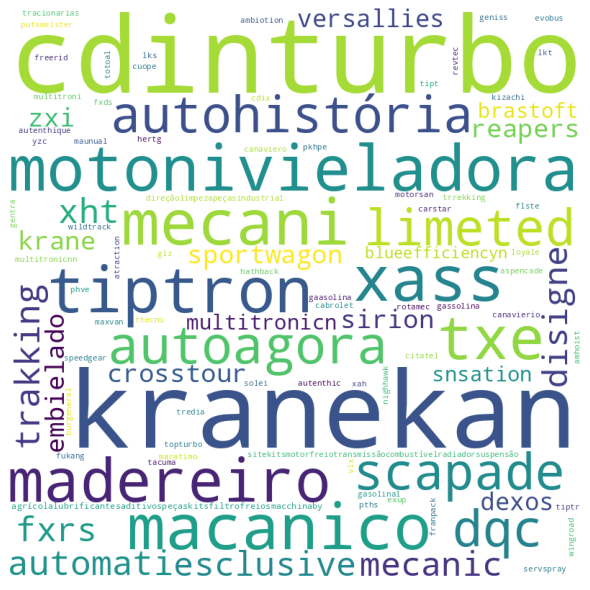

In [63]:
"""
Codigo retirado em:
https://www.geeksforgeeks.org/generating-word-cloud-python/, 
acesso 3/12/2020 
"""
df = pd.read_csv(r"ford_honda.csv", encoding ="UTF-8") 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.palavra: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                 stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

O gráfico acima, é nosso resultado final das palavras mais relevantes que apareceram em páginas nas quais existiam tanto a palavra ford quanto a palavra honda. E é muito interessante de se observar que palavras relacionadas a carros de fato apareceram. Tais como Design, mecanico, turbo, limited. E até alguns resultados muito inesperados como madeireiro.

## Conclusão

Algo relevante que é possivel de se observar com os resultados é que quando ford ou honda são análisadas separadamente, linguas estrangeiras aparecem entre as palavras mais relevantes. Analisando os resultados do dataset Ford&Honda, essas palavras estrageiras perdem espaço e sobram apenas palavras em português e as palavras em inglês do meio automobilistico.  
Num momento inicial, esperavamos ter entre essas 100 palavras relevantes do dataset Ford&Honda, palavras de conotação competitiva/comparativa por se tratarem de páginas nas quais aparecem nomes de empresas concorrentes. Contudo as palavras relevantes estão muito mais numa tendencia de mostrar caracteristicas de veiculos e alguns nomes de revendedoras.

